In [ ]:
# this just adds my simulation package to the path
import logging
import os
import pickle
import sys

sys.path.append("../")
adaptive_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if adaptive_root not in sys.path:
    sys.path.append(adaptive_root)
data_dir = os.path.join(adaptive_root, "notebooks", "fake_data")

logger = logging.getLogger("cmdstanpy")
logger.addHandler(logging.NullHandler())
logger.propagate = False
logger.setLevel(logging.CRITICAL)

In [ ]:
import copy
import pprint
from collections.abc import Iterable
from typing import Callable, Mapping

import numpy as np
import pandas as pd
from cmdstanpy import CmdStanModel
from simulation import fitters, simulators, utils
from tqdm.auto import tqdm

try:
    data = utils.load_latest_simulation(data_dir, prefix="optimal_p_single_expt")
    chick_variances = data["chick_variance_new"]
    diff_sigmas_vars = data["diff_sigmas_vars"]

    loaded = True
except FileNotFoundError:
    print("No data found in the specified directory.")

## Introduction

In this notebook, we explore the effect of varying hyperparameters on the optimal treatment ratio $p^*$ <u>***for a single experiment***</u>. We also examine two cases:
- we know the hyperparameters $\mu_\theta, \sigma_\theta, \mu_b, \sigma_b$
- we don't know these hyperparameters

Note that in both cases we assume $\sigma_0$ and $\sigma_1$ are known. Recall that the derivation of $p^*$ assumed we knew the above hyperparameters, giving the formula
$$
p^* \;=\; \min\left\{ 1,\; \left( 1 + \dfrac{\sigma_0^2}{n\,\sigma_b^2} \right) \middle/
             \left( 1 + \dfrac{\sigma_0}{\sigma_1} \right) \right\}.
$$
The only unknown here is $\sigma_b$. While $\sigma_b$ can be estimated from the data, having data from only one experiment means our estimate will be very noisy. Hence we fix $\sigma_b$ to its true value and examine how the optimal ratio differs when the hyperparameters are known or unknown.

## First case study: $\sigma_0 = \sigma_1$

If $\sigma_0 = \sigma_1$, then the above $p^*$ simplifies to
$$
p^* \;=\; \min\left\{ 1,\; \frac{1}{2}\left( 1 + \dfrac{\sigma_0^2}{n\,\sigma_b^2} \right)
             \right\}.
$$

We define $R := \sigma_0^2 / (n \sigma_b^2)$. If $R \geq 1$, then we see that $p^* \geq 1$ and thus we should allocate all subjects to treatment for the known-hyperparameter model. Also, we note that $p^* \geq 1/2$ for all values of the hyperparameters.

Now we verify the above using simulations. ***The hyperparameters were obtained by fitting the original multilevel model to the chicken data***. They are printed in the next cell along with the value of $R$.

In [ ]:
pp = pprint.PrettyPrinter()
pp.pprint(utils.CHICK_SIMULATOR.params())

R = utils.CHICK_SIGMA0**2 / (utils.CHICK_N * utils.CHICK_SIGMA_B**2)
print(f"\nR = {R}")

Thus we expect $p^* = 1$. Below we repeatedly generate a single experiment for each value of the treatment ratio $p$. For each repetition, we fit the Stan model and estimate the posterior variance of $\theta$. Then we average the variances for each value of $p$; the averages are plotted on the vertical axis.

In [ ]:
p_grid = np.linspace(0.1, 0.9, 9)
num_reps = 1
mlm_basic = CmdStanModel(
    stan_file=os.path.join("..", "models", "flat_hyperpriors.stan")
)
mlm_hyperparams = CmdStanModel(
    stan_file=os.path.join("..", "models", "oracle_hyperparameters.stan")
)

In [ ]:
def get_posterior_variances(
    base_simulator: simulators.ExperimentSimulator,
    p_grid: Iterable[float],
    num_reps: int,
):
    fits = {
        "Unknown hyperparameters": fitters.StanFitterBasic(mlm_basic),
        "Known hyperparameters": fitters.StanFitterBasicWithHyperparams(
            mlm_hyperparams
        ),
    }
    variances = {
        "Unknown hyperparameters": {},
        "Known hyperparameters": {},
        "Theoretical (known hyperparameters)": {},
    }

    for p in tqdm(p_grid, desc="Simulator", leave=False):
        curr_sim = copy.deepcopy(base_simulator)
        curr_sim.p = np.array([p])
        curr_sim.n = np.array([utils.CHICK_N])

        for variant in tqdm(
            ["Unknown hyperparameters", "Known hyperparameters"],
            desc="Type",
            leave=False,
        ):
            curr_variances = []
            fitter = fits[variant]

            for _ in tqdm(range(num_reps), desc="Repetitions", leave=False):
                expt = curr_sim.simulate()
                result = fitter.fit(expt, show_progress=False)
                theta_variance = np.var(result.theta)
                curr_variances.append(theta_variance)

            variances[variant][p] = np.mean(curr_variances)

        variances["Theoretical (known hyperparameters)"][p] = (
            utils.theta_posterior_variance(curr_sim)
        )

    return pd.DataFrame(variances)

In [5]:
from plotnine import (
    aes,
    geom_line,
    geom_point,
    geom_vline,
    ggplot,
    labs,
    scale_y_log10,
    theme_minimal,
)


def plot_variances(var_df, p_star=None):
    # Reshape to long format
    var_long = (
        var_df.reset_index()
        .rename(columns={"index": "p"})
        .melt(id_vars=["p"], var_name="Variant", value_name="Variance")
    )

    # Unpack singleton lists in the theoretical column
    var_long["Variance"] = var_long["Variance"].apply(
        lambda v: v[0]
        if isinstance(v, (list, tuple, np.ndarray)) and len(v) == 1
        else v
    )

    # Find the minimal-variance point for each Variant
    min_points = var_long.loc[
        var_long.groupby("Variant")["Variance"].idxmin()
    ].reset_index(drop=True)

    # Plot with log‑scaled y axis
    if p_star is not None:
        return (
            ggplot(var_long, aes(x="p", y="Variance", color="Variant"))
            + geom_line()
            + geom_point(data=min_points, size=3)
            + geom_vline(xintercept=p_star, linetype="dashed", color="grey")
            + scale_y_log10()
            + labs(
                x="Treatment Ratio p",
                y="Posterior Variance of θ (log scale)",
                title="Variance vs. Treatment Ratio",
            )
        )
    else:
        return (
            ggplot(var_long, aes(x="p", y="Variance", color="Variant"))
            + geom_line()
            + geom_point(data=min_points, size=3)
            + scale_y_log10()
            + labs(
                x="Treatment Ratio p",
                y="Posterior Variance of θ (log scale)",
                title="Variance vs. Treatment Ratio",
            )
        )

In [ ]:
chick_variances = get_posterior_variances(
    base_simulator=utils.CHICK_SIMULATOR,
    p_grid=p_grid,
    num_reps=num_reps,
)

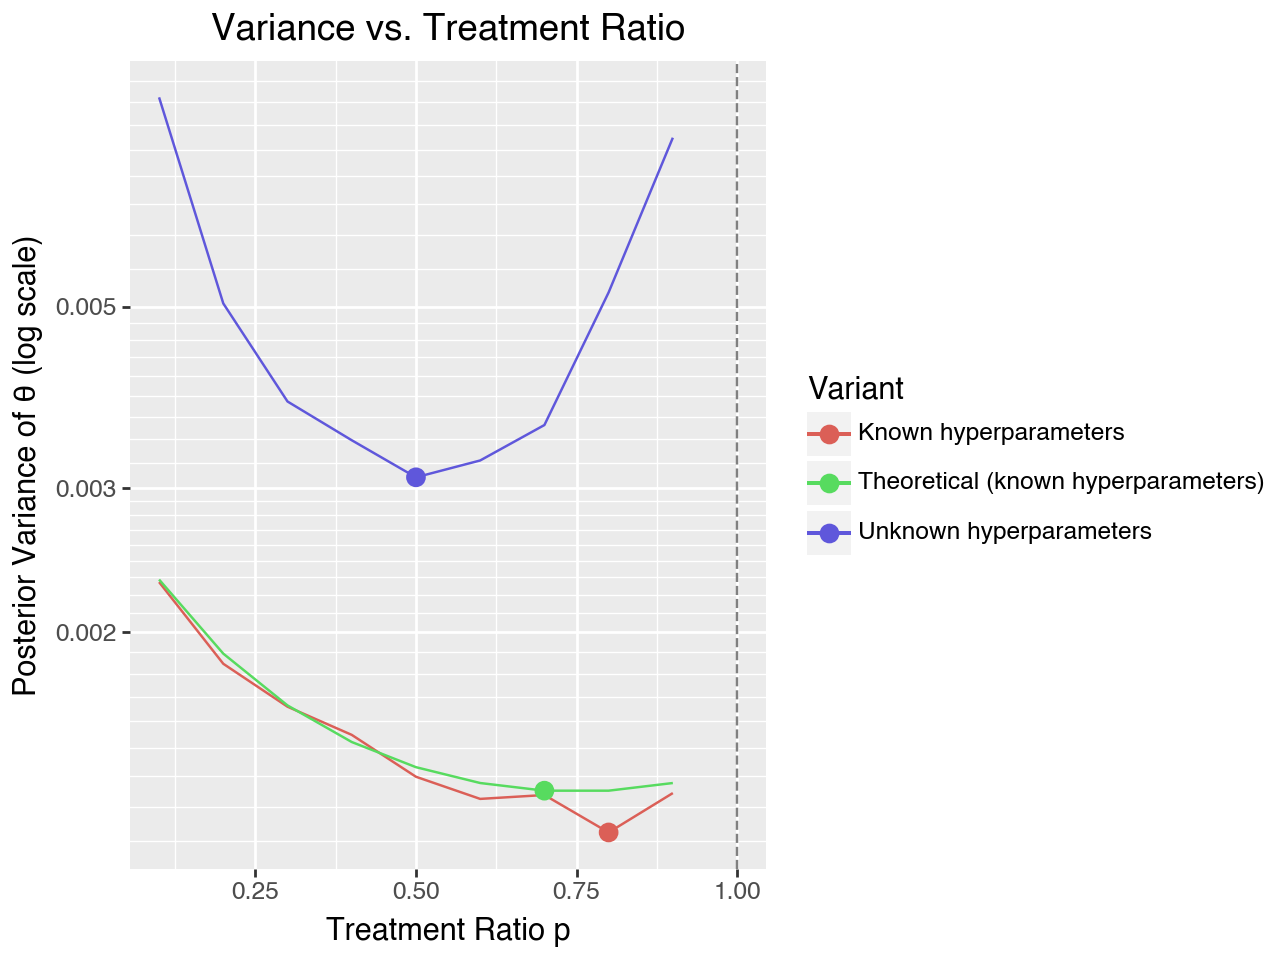

In [8]:
plot_variances(chick_variances, p_star=1)

The vertical dashed line is the value of $p^*$ for the known hyperparameter case. As the green and red lines are nearly the same, we can be confident that the theoretical formula for $\operatorname{var}(\theta \mid \overline{Y}_0, \overline{Y}_1)$ is correct. However, we also see that the posterior variance when the hyperparameters are unknown is minimized at a very different value of $p$ than for the known-hyperparameter case.

Let's examine this again where now we choose the hyperparameters so that $p^* < 1$. We choose to fix the same values of $\sigma_0$ and $\sigma_1$ and simply solve for $\sigma_b$:
$$\frac{ 1 }{ 2 } \left( 1 + \frac{ \sigma_0^2 }{ n \sigma_b^2 }\right) = p^* \implies \sigma_b = \frac{ \sigma_0 }{ \sqrt{ n(2 p^* - 1 )} }.$$
This gives us the values printed below for $p^* = 0.75$. All hyperparameters but $\sigma_b$ are unchanged from the original chicken setup.

In [ ]:
p_star_desired = 0.75
sigma_b_new = utils.CHICK_SIGMA0 / np.sqrt(utils.CHICK_N * (2 * p_star_desired - 1))
print(f"sigma_b = {sigma_b_new:.3f}")

In [ ]:
sim_new = copy.deepcopy(utils.CHICK_SIMULATOR)
sim_new.sigma_b = sigma_b_new

chick_variance_new = get_posterior_variances(
    base_simulator=sim_new,
    p_grid=p_grid,
    num_reps=num_reps,
)

In [ ]:
plot_variances(chick_variance_new, p_star=p_star_desired)

We see that the known-hyperparameter variance matches the theoretical variance well, but the unknown-hyperparameter variance is still quite different. In both these simulations, the unknown-hyperparameter variance is minimized near $p = 0.5$. Is this always true?

## Can the optimal ratio be somewhere other than $p=0.5$?

Here is a major difficulty: in finding the optimal allocation $p^*$, we assumed we knew the hyperparameters. As the above graphs show, the theoretical result and the simulation match well *if the posterior mean is obtained using the correctly specified model*. The problem is that the unknown-hyperparameter model samples the posterior of $\theta$ with flat priors on the hyperparameters.

In [ ]:
sim_diff_sigmas = copy.deepcopy(utils.CHICK_SIMULATOR)
sim_diff_sigmas.sigma1 = 3 * sim_diff_sigmas.sigma0
diff_sigmas_vars = get_posterior_variances(sim_diff_sigmas, p_grid=p_grid, num_reps=5)

In [ ]:
diff_sigmas_vars

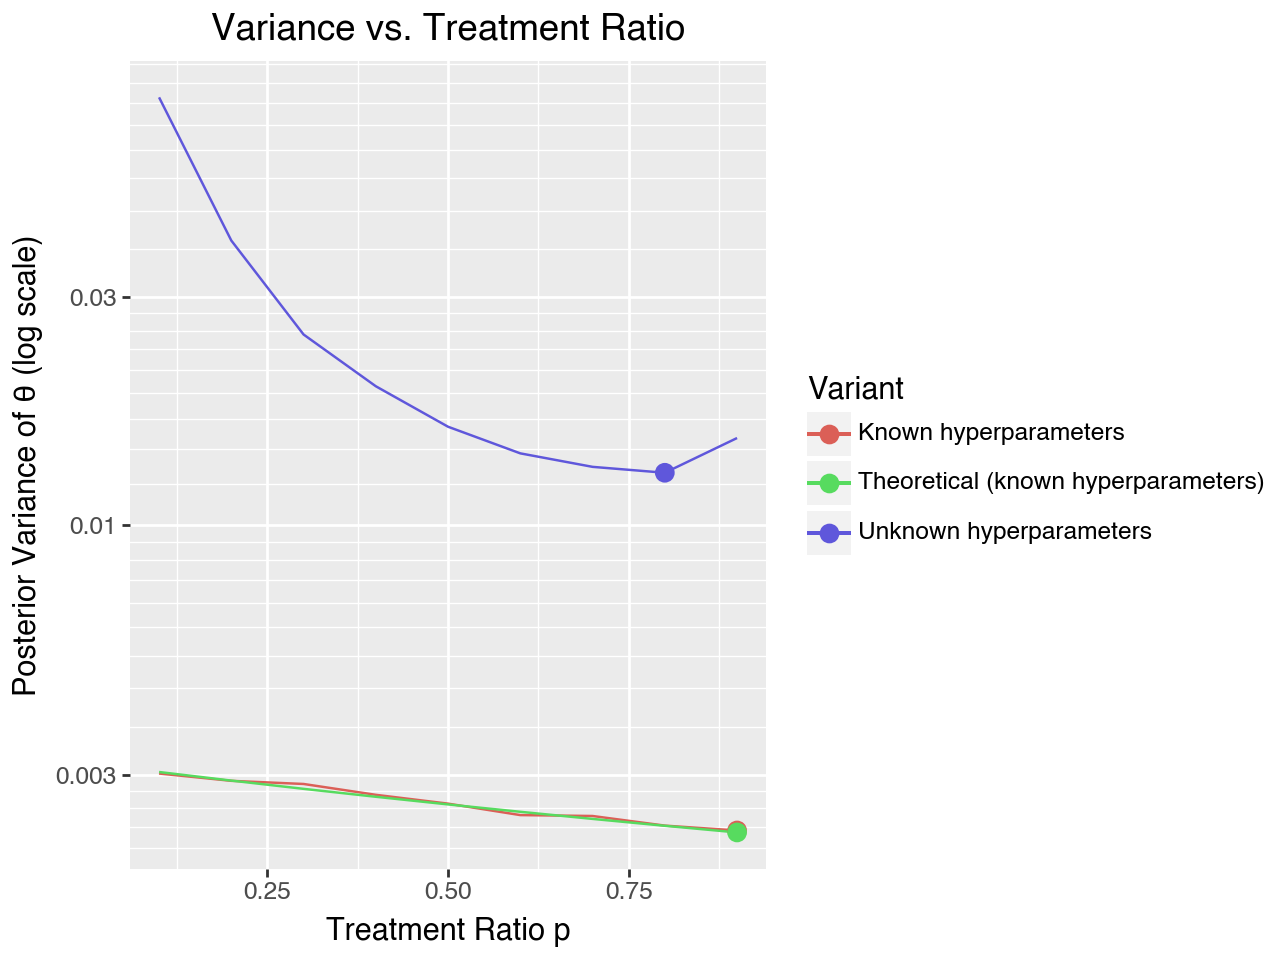

In [9]:
plot_variances(diff_sigmas_vars)


In [ ]:
data = {
    "chick_variance_new": chick_variances,
    "diff_sigmas_vars": diff_sigmas_vars,
}
utils.save_simulation(
    results=data,
    data_dir=os.path.join(adaptive_root, "notebooks", "fake_data"),
    prefix="optimal_p_single_expt",
)

Let's examine how the unknown-hyperparameter variance varies with $R := \sigma_0^2 / (n \sigma_b^2)$. As we just did, we fix $\sigma_0 = \sigma_1$ and change $\sigma_b$ to produce the desired value of $R$.

In [ ]:
R_grid = np.linspace(0.1, 300, 20)
sims_R = {}
for R_value in R_grid:
    sim = copy.deepcopy(utils.CHICK_SIMULATOR)
    sim.params["sigma_b"] = utils.CHICK_SIGMA0 / np.sqrt(utils.CHICK_N * R_value)
    sims_R[R_value] = sim

unknown_hyperparameters_fit = fitters.StanFitterBasic(mlm_basic)
variances = {
    "Unknown hyperparameters": {},
    "Theoretical (known hyperparameters)": {},
}

# store the best p for each R_value in the unknown-hyperparameter model
p_star_uhp = {}
for R_value, sim in tqdm(sims_R.items(), desc="Simulator", leave=False):
    for p in tqdm(p_grid, desc="p", leave=False):
        curr_sim = copy.deepcopy(sim)
        curr_sim.p = np.array([p])
        curr_sim.n = np.array([utils.CHICK_N])

        curr_variances = []

        for _ in tqdm(range(10), desc="Repetitions", leave=False):
            expt = curr_sim.simulate()
            result = unknown_hyperparameters_fit.fit(expt, show_progress=False)
            theta_variance = np.var(result.theta)
            curr_variances.append(theta_variance)

        variances["Unknown hyperparameters"][p] = np.mean(curr_variances)

    p_star_uhp[R_value] = min(
        variances["Unknown hyperparameters"],
        key=variances["Unknown hyperparameters"].get,
    )


In [ ]:
from plotnine import scale_x_log10

# Prepare a dataframe of R values vs. optimal p for the unknown‐hyperparameter model
df_pstar = pd.DataFrame(
    {"R": list(p_star_uhp.keys()), "p_star": list(p_star_uhp.values())}
)

# Plot optimal p vs. R on a log‐scaled x axis
(
    ggplot(df_pstar, aes(x="R", y="p_star"))
    + geom_line()
    + geom_point()
    + labs(
        x="R = σ₀² / (n σ_b²)",
        y="Optimal p (unknown hyperparameters)",
        title="Optimal Treatment Ratio p* vs. R",
    )
)

Based on the above, it appears that if the unknown-hyperparameter model is used to find the posterior mean for a single experiment, then we might not be able to do better than the 50% treatment ratio.